=== Training with BAD SMALL initialization ===
Epoch 1/5 | Loss: 2.3027 | Test Acc: 10.00%
Epoch 2/5 | Loss: 2.3027 | Test Acc: 10.00%
Epoch 3/5 | Loss: 2.3027 | Test Acc: 10.00%
Epoch 4/5 | Loss: 2.3027 | Test Acc: 10.00%
Epoch 5/5 | Loss: 2.3027 | Test Acc: 10.00%
=== Training with Xavier Initialization ===
Epoch 1/5 | Loss: 0.5885 | Test Acc: 82.61%
Epoch 2/5 | Loss: 0.4208 | Test Acc: 85.47%
Epoch 3/5 | Loss: 0.3840 | Test Acc: 85.28%
Epoch 4/5 | Loss: 0.3631 | Test Acc: 87.68%
Epoch 5/5 | Loss: 0.3436 | Test Acc: 88.10%
=== Training with He Initialization ===
Epoch 1/5 | Loss: 0.5419 | Test Acc: 84.89%
Epoch 2/5 | Loss: 0.4116 | Test Acc: 85.04%
Epoch 3/5 | Loss: 0.3779 | Test Acc: 86.54%
Epoch 4/5 | Loss: 0.3498 | Test Acc: 87.04%
Epoch 5/5 | Loss: 0.3325 | Test Acc: 87.75%
=== Training with Gradient Clipping ===
Epoch 1/5 | Loss: 2.3026 | Test Acc: 10.00%
Epoch 2/5 | Loss: 2.3026 | Test Acc: 10.00%
Epoch 3/5 | Loss: 2.3026 | Test Acc: 10.00%
Epoch 4/5 | Loss: 2.3026 | Test Acc: 

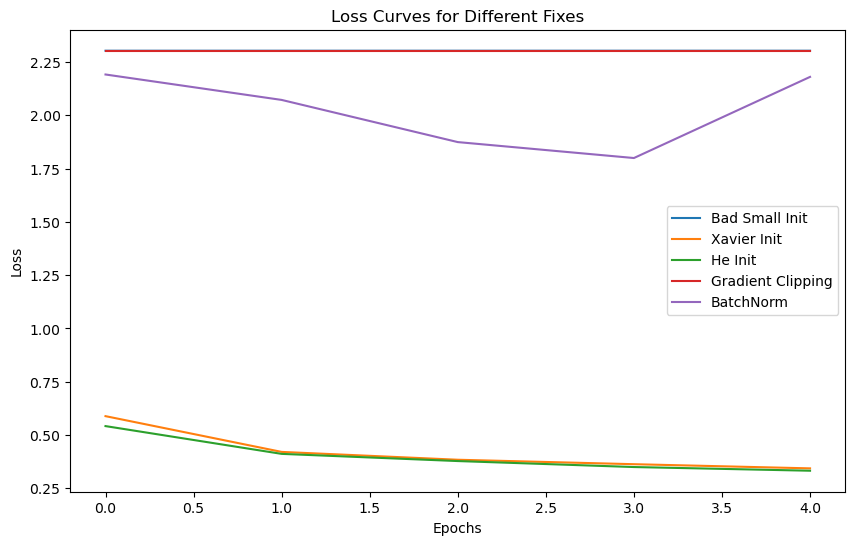

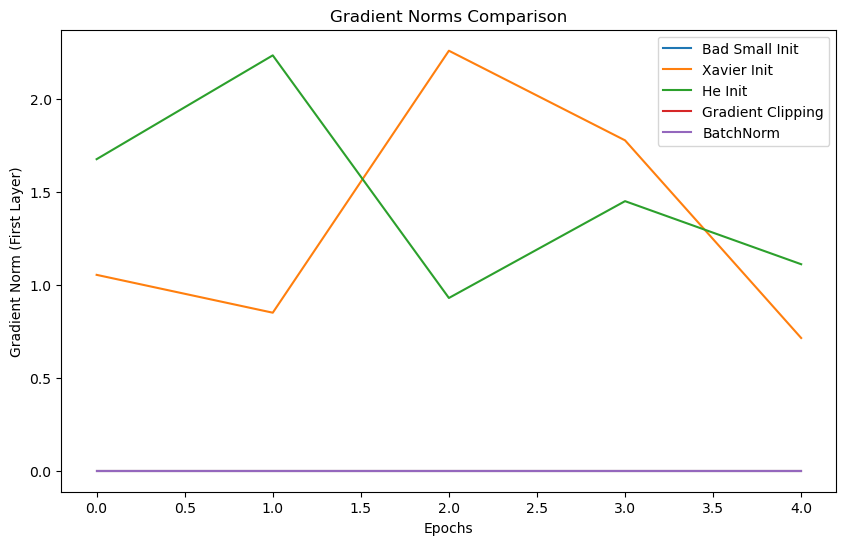

              Method  Test Accuracy
0     Bad Small Init         0.1000
1        Xavier Init         0.8810
2            He Init         0.8775
3  Gradient Clipping         0.1000
4          BatchNorm         0.0994


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.X = self.data.iloc[:, 1:].values.astype(np.float32) / 255.0
        self.y = self.data.iloc[:, 0].values.astype(np.int64)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

train_dataset = FashionMNISTDataset('fashion-mnist_train.csv')
test_dataset  = FashionMNISTDataset('fashion-mnist_test.csv')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

class DeepFC(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, num_layers=10, num_classes=10, use_bn=False):
        super().__init__()
        layers = []
        for i in range(num_layers):
            in_size = input_size if i==0 else hidden_size
            layers.append(nn.Linear(in_size, hidden_size))
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, num_classes))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

def bad_init_small(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 0.0001)
        nn.init.constant_(m.bias, 0)

def bad_init_large(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 5.0)
        nn.init.constant_(m.bias, 0)

def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)

def he_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        nn.init.constant_(m.bias, 0)

def train_model(model, train_loader, test_loader, optimizer, criterion, epochs=10, clip_grad=False, max_norm=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    train_losses = []
    grad_norms = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            if clip_grad:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        norms = []
        for p in model.parameters():
            if p.grad is not None:
                norms.append(p.grad.norm().item())
        grad_norms.append(norms)
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                _, predicted = torch.max(outputs, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        acc = correct / total
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Test Acc: {acc*100:.2f}%")
    
    return train_losses, grad_norms, acc

model_small = DeepFC()
model_small.apply(bad_init_small)
optimizer = optim.Adam(model_small.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
print("=== Training with BAD SMALL initialization ===")
loss_small, grads_small, acc_small = train_model(model_small, train_loader, test_loader, optimizer, criterion, epochs=5)

model_xavier = DeepFC()
model_xavier.apply(xavier_init)
optimizer = optim.Adam(model_xavier.parameters(), lr=0.001)
print("=== Training with Xavier Initialization ===")
loss_xavier, grads_xavier, acc_xavier = train_model(model_xavier, train_loader, test_loader, optimizer, criterion, epochs=5)

model_he = DeepFC()
model_he.apply(he_init)
optimizer = optim.Adam(model_he.parameters(), lr=0.001)
print("=== Training with He Initialization ===")
loss_he, grads_he, acc_he = train_model(model_he, train_loader, test_loader, optimizer, criterion, epochs=5)

model_clip = DeepFC()
model_clip.apply(bad_init_large)
optimizer = optim.Adam(model_clip.parameters(), lr=0.001)
print("=== Training with Gradient Clipping ===")
loss_clip, grads_clip, acc_clip = train_model(model_clip, train_loader, test_loader, optimizer, criterion, epochs=5, clip_grad=True, max_norm=5)

model_bn = DeepFC(use_bn=True)
model_bn.apply(bad_init_small)
optimizer = optim.Adam(model_bn.parameters(), lr=0.001)
print("=== Training with Batch Normalization ===")
loss_bn, grads_bn, acc_bn = train_model(model_bn, train_loader, test_loader, optimizer, criterion, epochs=5)

plt.figure(figsize=(10,6))
plt.plot(loss_small, label='Bad Small Init')
plt.plot(loss_xavier, label='Xavier Init')
plt.plot(loss_he, label='He Init')
plt.plot(loss_clip, label='Gradient Clipping')
plt.plot(loss_bn, label='BatchNorm')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves for Different Fixes")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot([g[0] for g in grads_small], label='Bad Small Init')
plt.plot([g[0] for g in grads_xavier], label='Xavier Init')
plt.plot([g[0] for g in grads_he], label='He Init')
plt.plot([g[0] for g in grads_clip], label='Gradient Clipping')
plt.plot([g[0] for g in grads_bn], label='BatchNorm')
plt.xlabel("Epochs")
plt.ylabel("Gradient Norm (First Layer)")
plt.title("Gradient Norms Comparison")
plt.legend()
plt.show()

acc_table = pd.DataFrame({
    'Method': ['Bad Small Init', 'Xavier Init', 'He Init', 'Gradient Clipping', 'BatchNorm'],
    'Test Accuracy': [acc_small, acc_xavier, acc_he, acc_clip, acc_bn]
})
print(acc_table)
